In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [ ]:
def array_to_dist(dataset, feature_name, label, step):
    # 左闭右开
    if dataset is None:
        return []
    
    min_val = min(dataset[feature_name])
    max_val = max(dataset[feature_name]) 
    
    #print('feature:{},min:{}, max:{}'.format(feature_name, min_val, max_val))
    
    #print('min:{}, max:{}'.format(min_val, max_val))
    val = np.linspace(min_val, max_val, num=step+1)
    val = val.tolist()
    #print('val:{}'.format(val))
    
    dist=[]
    deal_data = dataset.loc[dataset['label']==label]
    if deal_data is None:
        return []
    sum_val = 0
    for i in range (step):
       # print('i:{},i+1:{}'.format(val[i], val[i+1]))
        x = deal_data.loc[(deal_data[feature_name]>=val[i]) & (deal_data[feature_name]<val[i+1])]
        sum_val = sum_val + len(x)
        val_size = len(x)
        dist.append(val_size)
    
    
    for i, val in enumerate(dist):
        if sum_val == 0:
            break
        dist[i] = dist[i]/sum_val
        if dist[i] == 0:
            dist[i] = 0.000001
    return dist
    

def kl_divergence(feature_name, dataset):
    '''
    计算feature_name对应的kl散度
    feature_name:特征名称
    dataset 数据集合
    面临一个问题，normal和disease两个数据长度不一致，需要对齐
    就算长度对齐也不对，需要进行分桶，计算好分布
    '''
   # neg = array_to_dist(dataset, feature_name, 0, 20)
    #pos = array_to_dist(dataset, feature_name, 1, 20)
    
    #print('neg:{},pos:{}'.format(neg, pos))
    '''
    这里使用numpy.histogram来代替之前自己写的函数，看看速度会提升不
    '''
    neg_feature_data = dataset[dataset['label'] == 0][feature_name] # 负样本数据
    pos_feature_data = dataset[dataset['label'] == 1][feature_name] # 正样本数据
    
    min_value = pos_feature_data.min() if neg_feature_data.min() > pos_feature_data.min() else neg_feature_data.min()
    max_value = neg_feature_data.max() if neg_feature_data.max() > pos_feature_data.max() else pos_feature_data.max()
    neg_hist, neg_bin = np.histogram(neg_feature_data, bins = 10, range=(min_value, max_value), density = True)
    pos_hist, pos_bin = np.histogram(pos_feature_data, bins = 10, range=(min_value, max_value), density = True)
    pos_hist[pos_hist == 0] = 1e-7
    neg_hist[neg_hist == 0] = 1e-7
    return entropy(neg_hist, pos_hist, base = 2)

# 获取所有df的
def get_all_kl_divergence(df):
    features =[]
    feature_kl = []
    size = len(df.columns)
    i = 0
    for feature in df.columns:
        if feature == 'label':
            continue
        features.append(feature)
        feature_kl.append(kl_divergence(feature, df))
        i = i + 1
        print('process:{}'.format(i))
    kl_feature_dataset = pd.DataFrame()
    kl_feature_dataset['feature_name'] = features
    kl_feature_dataset['kl_divergence'] = feature_kl
    final = kl_feature_dataset.sort_values('kl_divergence', ascending=False)
    return final

In [ ]:
def array_to_hist(arr):
    # 数组生成hist

In [ ]:
df = pd.read_csv('final_train_v4.csv', index_col = 0)
#normal_df = df[df['label'] == 0]

#disease_df = df[df['label'] == 1].sample(n = 60)

#df1 = normal_df.append(disease_df)

dd = get_all_kl_divergence(df)

In [ ]:
df['CD5L']

In [ ]:
dd.head(30)

In [ ]:
def plot_train(feature_name, dataset):
    '''
     feature_name : 特征名称
     dataset: 训练集合的dataFrame的全集
    '''
    if  dataset is None:
        return
    if feature_name is None:
        return
    # 获取最后正样本和负样本两种数据的差异
    #ax.set_title('{}患病和正常组的数据分布图'.format(feature_name))
    #f, ax= plt.subplots()
    g = sns.displot(dataset, x=feature_name, kind='kde', hue='label', fill=True, rug=True)
    #g.set_axis_labels('{}'.format(feature_name))
    #g.set_titles('ontrol group and disease group PDF',)
    #g.set_ylabels("control group and disease group PDF")
    g.ax.set_title(u'{} disease group and control group PDF'.format(feature_name))
    #g.savefig("{}.png".format(feature_name))
    #sns.displot(disease_data,kind='kde')

In [ ]:
plot_train('FXYD1', df1)

In [ ]:
choosed_features = dd[dd['kl_divergence'] > 3].reset_index(drop = True)
choosed_features

In [ ]:
len(choosed_features)

In [ ]:
choosed_features

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from datetime import datetime
from tensorflow import keras

global train, test, train_ds, test_ds
def df_to_dataset(dataframe, shuffle=True, batch_size=20):
  dataframe1 = dataframe.copy()
  labels = dataframe1.pop('label')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe1), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe1))
  ds = ds.batch(batch_size)
  return ds

# 定义一个函数，输入数据，然后将列作为feature_column 然后构建lr模型来看哪个特征重要
def train_model(data):
    global train, test, train_ds, test_ds
    if data is None:
        return None
    if len(data.columns) == 0:
        return None
    feature_columns = []
    for feature in data.columns:
        if feature == 'label':
            continue
        feature_columns.append(tf.feature_column.numeric_column(feature))
    
    # 生成训练数据
    batch_size=20
    train, test = train_test_split(data, test_size=0.2)
    train_ds = df_to_dataset(train, batch_size=batch_size)
    test_ds = df_to_dataset(test, batch_size=batch_size)
    
    model = tf.keras.Sequential([
          tf.keras.layers.DenseFeatures(feature_columns),
          #tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC','accuracy', 'Recall', 'Precision'])
    logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

    model.fit(train_ds,
          validation_data = test_ds,
          epochs = 100,
          callbacks = [tensorboard_callback])
    return model
    

In [ ]:
#df_final = df[choosed_features['feature_name'] + ['label']]
#df_final['label'] = df['label']
#choosed_features['feature_name'].values.insert(['label'])
#choosed_features['feature_name'].append('label')
index_columns = np.append(choosed_features['feature_name'].values, ['label'])
df_final = df[index_columns]

In [ ]:
df_final.head(10)

In [ ]:
df_t2 = shuffle(df_final)
train_model(df_t2)

In [ ]:
df = pd.read_csv('final_train_v4.csv', index_col = 0)

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.config.experimental.set_memory_growth = True
df_t2 = shuffle(df)
train_model(df_t2)

In [ ]:
df_final.to_csv('final_choosed_feature_v1.csv')

In [3]:
df = pd.read_csv('final_choosed_feature_v1.csv', index_col=0)
df.columns

Index(['GYPE', 'SSTR4', 'NECAB1', 'C10orf67', 'SGCG', 'E2F3', 'JPH4', 'HBM',
       'CCDC54', 'ADCY8',
       ...
       'MAPK4', 'CMTM2', 'AJAP1', 'PADI4', 'SLC4A1', 'NLRC4', 'PECAM1',
       'TAMALIN', 'SIRPD', 'label'],
      dtype='object', length=195)

In [34]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt
import os
plt.style.use('science')
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
plt.style.use(['science','ieee'])

def modify_label(label):
    if label == 0:
        return -1
    return label

def svm_train():
    df = pd.read_csv('final_train_v4.csv')
    df['label'] = df['label'].map(modify_label)
    labels = df['label'].values
    features = df.drop(['label', 'Unnamed: 0'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = ts(feature_arr, labels, test_size=0.3)
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds

    

In [10]:
def deep_model_train():
    feature_df = pd.read_csv('final_choosed_feature_v1.csv', index_col=0)
    df_t2 = shuffle(feature_df)
    return train_model(df_t2)
    

In [41]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression

plt.style.use('science')
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
plt.style.use(['science','ieee'])

# 逻辑回归的训练数据
def lr_train():
    df = pd.read_csv('final_train_v4.csv', index_col=0)
    labels = df['label'].values
    features = df.drop(['label'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = ts(feature_arr, labels, test_size=0.4)
    
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    preds = clf.predict(X_test)
    
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds

In [16]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('science')
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
plt.style.use(['science','ieee'])

# knn的训练数据
def knn_train():
    df = pd.read_csv('final_train_v4.csv', index_col=0)
    labels = df['label'].values
    features = df.drop(['label'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = ts(feature_arr, labels, test_size=0.3)
    
    knn = KNeighborsClassifier(n_neighbors=50)
    
    clf = knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds

In [17]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier


plt.style.use('science')
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
plt.style.use(['science','ieee'])

# rf的训练数据
def rf_train():
    df = pd.read_csv('final_train_v4.csv', index_col=0)
    labels = df['label'].values
    features = df.drop(['label'], axis=1)
    feature_arr = features.values
    X_train,X_test,y_train,y_test = ts(feature_arr, labels, test_size=0.3)
    
    rf = RandomForestClassifier(random_state=0, n_estimators=1)
    
    clf = rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    
    targs = y_test 
    false_positive_rate,true_positive_rate,thresholds=roc_curve(targs, preds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    return false_positive_rate, true_positive_rate, thresholds

In [44]:
model = deep_model_train()

Epoch 1/100
     14/Unknown - 4s 301ms/step - loss: 1023.9271 - AUC: 0.4821 - accuracy: 0.8679 - Recall: 0.9643 - Precision: 0.8967

2021-10-04 20:42:11.007875: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


     24/Unknown - 4s 181ms/step - loss: 841.7507 - AUC: 0.4790 - accuracy: 0.8668 - Recall: 0.9579 - Precision: 0.9011

2021-10-04 20:42:11.340266: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 7s 290ms/step - loss: 841.7507 - AUC: 0.4790 - accuracy: 0.8668 - Recall: 0.9579 - Precision: 0.9011 - val_loss: 0.0000e+00 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00
Epoch 2/100
24/24 [==============================] - 1s 21ms/step - loss: 303.5745 - AUC: 0.5866 - accuracy: 0.8097 - Recall: 0.8621 - Precision: 0.9225 - val_loss: 160.5915 - val_AUC: 0.7701 - val_accuracy: 0.8067 - val_Recall: 0.8190 - val_Precision: 0.9556
Epoch 3/100


2021-10-04 20:42:14.330760: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 191.3554 - AUC: 0.7435 - accuracy: 0.8245 - Recall: 0.8435 - Precision: 0.9576 - val_loss: 120.7014 - val_AUC: 0.8048 - val_accuracy: 0.8739 - val_Recall: 0.8952 - val_Precision: 0.9592
Epoch 4/100


2021-10-04 20:42:14.855572: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 154.3777 - AUC: 0.8065 - accuracy: 0.8837 - Recall: 0.9019 - Precision: 0.9674 - val_loss: 90.2165 - val_AUC: 0.8418 - val_accuracy: 0.8908 - val_Recall: 0.9048 - val_Precision: 0.9694
Epoch 5/100


2021-10-04 20:42:15.390074: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 117.6619 - AUC: 0.8094 - accuracy: 0.9070 - Recall: 0.9299 - Precision: 0.9660 - val_loss: 65.8356 - val_AUC: 0.8490 - val_accuracy: 0.8992 - val_Recall: 0.9143 - val_Precision: 0.9697
Epoch 6/100


2021-10-04 20:42:15.914636: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 114.3682 - AUC: 0.8589 - accuracy: 0.9049 - Recall: 0.9159 - Precision: 0.9776 - val_loss: 44.9623 - val_AUC: 0.9214 - val_accuracy: 0.9160 - val_Recall: 0.9143 - val_Precision: 0.9897
Epoch 7/100


2021-10-04 20:42:16.441696: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 98.5401 - AUC: 0.8690 - accuracy: 0.9239 - Recall: 0.9393 - Precision: 0.9757 - val_loss: 45.5896 - val_AUC: 0.8690 - val_accuracy: 0.9328 - val_Recall: 0.9524 - val_Precision: 0.9709
Epoch 8/100


2021-10-04 20:42:16.957866: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 84.0978 - AUC: 0.8588 - accuracy: 0.9429 - Recall: 0.9626 - Precision: 0.9740 - val_loss: 31.1999 - val_AUC: 0.9405 - val_accuracy: 0.9496 - val_Recall: 0.9524 - val_Precision: 0.9901
Epoch 9/100


2021-10-04 20:42:17.479405: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 70.1193 - AUC: 0.8889 - accuracy: 0.9429 - Recall: 0.9556 - Precision: 0.9808 - val_loss: 27.7250 - val_AUC: 0.9452 - val_accuracy: 0.9580 - val_Recall: 0.9619 - val_Precision: 0.9902
Epoch 10/100


2021-10-04 20:42:17.995209: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 65.5865 - AUC: 0.8871 - accuracy: 0.9577 - Recall: 0.9743 - Precision: 0.9789 - val_loss: 22.7475 - val_AUC: 0.9452 - val_accuracy: 0.9580 - val_Recall: 0.9619 - val_Precision: 0.9902
Epoch 11/100


2021-10-04 20:42:18.510231: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 58.5318 - AUC: 0.9082 - accuracy: 0.9598 - Recall: 0.9720 - Precision: 0.9835 - val_loss: 18.4803 - val_AUC: 0.9500 - val_accuracy: 0.9664 - val_Recall: 0.9714 - val_Precision: 0.9903
Epoch 12/100


2021-10-04 20:42:19.021094: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 52.1613 - AUC: 0.9082 - accuracy: 0.9598 - Recall: 0.9720 - Precision: 0.9835 - val_loss: 16.6115 - val_AUC: 0.9548 - val_accuracy: 0.9748 - val_Recall: 0.9810 - val_Precision: 0.9904
Epoch 13/100


2021-10-04 20:42:19.539058: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 46.2189 - AUC: 0.8994 - accuracy: 0.9619 - Recall: 0.9766 - Precision: 0.9812 - val_loss: 13.8771 - val_AUC: 0.9548 - val_accuracy: 0.9748 - val_Recall: 0.9810 - val_Precision: 0.9904
Epoch 14/100


2021-10-04 20:42:20.049456: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 42.2067 - AUC: 0.9293 - accuracy: 0.9619 - Recall: 0.9696 - Precision: 0.9881 - val_loss: 13.1517 - val_AUC: 0.9548 - val_accuracy: 0.9748 - val_Recall: 0.9810 - val_Precision: 0.9904
Epoch 15/100


2021-10-04 20:42:20.568939: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 23ms/step - loss: 36.4819 - AUC: 0.8907 - accuracy: 0.9641 - Recall: 0.9813 - Precision: 0.9790 - val_loss: 10.7654 - val_AUC: 0.9548 - val_accuracy: 0.9748 - val_Recall: 0.9810 - val_Precision: 0.9904
Epoch 16/100


2021-10-04 20:42:21.123911: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 34.0291 - AUC: 0.9328 - accuracy: 0.9683 - Recall: 0.9766 - Precision: 0.9882 - val_loss: 8.4891 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 17/100


2021-10-04 20:42:21.640468: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 23ms/step - loss: 28.0757 - AUC: 0.9351 - accuracy: 0.9725 - Recall: 0.9813 - Precision: 0.9882 - val_loss: 7.2735 - val_AUC: 0.9548 - val_accuracy: 0.9748 - val_Recall: 0.9810 - val_Precision: 0.9904


2021-10-04 20:42:22.166116: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 18/100
24/24 [==============================] - 1s 21ms/step - loss: 25.0212 - AUC: 0.9164 - accuracy: 0.9746 - Recall: 0.9883 - Precision: 0.9837 - val_loss: 5.3000 - val_AUC: 0.9548 - val_accuracy: 0.9748 - val_Recall: 0.9810 - val_Precision: 0.9904
Epoch 19/100


2021-10-04 20:42:22.713589: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 21.9985 - AUC: 0.9374 - accuracy: 0.9767 - Recall: 0.9860 - Precision: 0.9883 - val_loss: 6.0145 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 20/100


2021-10-04 20:42:23.241356: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 21.6192 - AUC: 0.9386 - accuracy: 0.9789 - Recall: 0.9883 - Precision: 0.9883 - val_loss: 4.7356 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 21/100


2021-10-04 20:42:23.748456: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 18.0082 - AUC: 0.9719 - accuracy: 0.9852 - Recall: 0.9883 - Precision: 0.9953 - val_loss: 3.8738 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 22/100


2021-10-04 20:42:24.269748: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 11.0281 - AUC: 0.9398 - accuracy: 0.9810 - Recall: 0.9907 - Precision: 0.9883 - val_loss: 1.6976 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 23/100


2021-10-04 20:42:24.789914: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 13.4719 - AUC: 0.9508 - accuracy: 0.9831 - Recall: 0.9907 - Precision: 0.9907 - val_loss: 1.9649 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 24/100


2021-10-04 20:42:25.301859: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 23ms/step - loss: 10.5984 - AUC: 0.9842 - accuracy: 0.9894 - Recall: 0.9907 - Precision: 0.9976 - val_loss: 0.5628 - val_AUC: 0.9952 - val_accuracy: 0.9916 - val_Recall: 0.9905 - val_Precision: 1.0000
Epoch 25/100


2021-10-04 20:42:25.843888: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 10.6436 - AUC: 0.9310 - accuracy: 0.9831 - Recall: 0.9953 - Precision: 0.9861 - val_loss: 0.6617 - val_AUC: 0.9952 - val_accuracy: 0.9916 - val_Recall: 0.9905 - val_Precision: 1.0000
Epoch 26/100


2021-10-04 20:42:26.356231: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 8.9648 - AUC: 0.9743 - accuracy: 0.9894 - Recall: 0.9930 - Precision: 0.9953 - val_loss: 0.5239 - val_AUC: 0.9643 - val_accuracy: 0.9916 - val_Recall: 1.0000 - val_Precision: 0.9906
Epoch 27/100


2021-10-04 20:42:26.874257: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 8.9496 - AUC: 0.9643 - accuracy: 0.9894 - Recall: 0.9953 - Precision: 0.9930 - val_loss: 0.2287 - val_AUC: 0.9952 - val_accuracy: 0.9916 - val_Recall: 0.9905 - val_Precision: 1.0000
Epoch 28/100


2021-10-04 20:42:27.377895: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 5.8453 - AUC: 0.9643 - accuracy: 0.9894 - Recall: 0.9953 - Precision: 0.9930 - val_loss: 0.7984 - val_AUC: 0.9857 - val_accuracy: 0.9748 - val_Recall: 0.9714 - val_Precision: 1.0000
Epoch 29/100


2021-10-04 20:42:27.878528: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 5.1400 - AUC: 0.9643 - accuracy: 0.9894 - Recall: 0.9953 - Precision: 0.9930 - val_loss: 0.0018 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_Recall: 1.0000 - val_Precision: 1.0000
Epoch 30/100


2021-10-04 20:42:28.386267: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 3.8745 - AUC: 0.9754 - accuracy: 0.9915 - Recall: 0.9953 - Precision: 0.9953 - val_loss: 3.5607e-04 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_Recall: 1.0000 - val_Precision: 1.0000
Epoch 31/100


2021-10-04 20:42:28.887614: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 3.8301 - AUC: 0.9521 - accuracy: 0.9852 - Recall: 0.9930 - Precision: 0.9907 - val_loss: 1.2850 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 32/100


2021-10-04 20:42:29.389911: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 3.7225 - AUC: 0.9521 - accuracy: 0.9852 - Recall: 0.9930 - Precision: 0.9907 - val_loss: 0.7062 - val_AUC: 0.9595 - val_accuracy: 0.9832 - val_Recall: 0.9905 - val_Precision: 0.9905
Epoch 33/100


2021-10-04 20:42:29.888659: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 3.4852 - AUC: 0.9743 - accuracy: 0.9894 - Recall: 0.9930 - Precision: 0.9953 - val_loss: 3.6225 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 34/100


2021-10-04 20:42:30.386122: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 1.7443 - AUC: 0.9667 - accuracy: 0.9937 - Recall: 1.0000 - Precision: 0.9930 - val_loss: 4.8220 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 35/100


2021-10-04 20:42:30.883670: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.9403 - AUC: 0.9866 - accuracy: 0.9937 - Recall: 0.9953 - Precision: 0.9977 - val_loss: 4.4840 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 36/100


2021-10-04 20:42:31.387284: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 1.1560 - AUC: 0.9889 - accuracy: 0.9979 - Recall: 1.0000 - Precision: 0.9977 - val_loss: 5.6701 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 37/100


2021-10-04 20:42:31.886067: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 1.1529 - AUC: 0.9877 - accuracy: 0.9958 - Recall: 0.9977 - Precision: 0.9977 - val_loss: 5.7999 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 38/100


2021-10-04 20:42:32.388834: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 0.7787 - AUC: 0.9889 - accuracy: 0.9979 - Recall: 1.0000 - Precision: 0.9977 - val_loss: 6.8824 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 39/100


2021-10-04 20:42:32.889595: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 0.6944 - AUC: 0.9866 - accuracy: 0.9937 - Recall: 0.9953 - Precision: 0.9977 - val_loss: 7.1610 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 40/100


2021-10-04 20:42:33.391835: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 1.0093 - AUC: 0.9778 - accuracy: 0.9958 - Recall: 1.0000 - Precision: 0.9953 - val_loss: 7.1685 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 41/100


2021-10-04 20:42:33.889703: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 0.3497 - AUC: 0.9889 - accuracy: 0.9979 - Recall: 1.0000 - Precision: 0.9977 - val_loss: 9.8166 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 42/100


2021-10-04 20:42:34.391920: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 0.3048 - AUC: 0.9988 - accuracy: 0.9979 - Recall: 0.9977 - Precision: 1.0000 - val_loss: 8.3195 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 43/100


2021-10-04 20:42:34.888563: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 0.5890 - AUC: 0.9778 - accuracy: 0.9958 - Recall: 1.0000 - Precision: 0.9953 - val_loss: 9.5552 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 44/100


2021-10-04 20:42:35.385817: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 0.2651 - AUC: 0.9988 - accuracy: 0.9979 - Recall: 0.9977 - Precision: 1.0000 - val_loss: 9.0025 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 45/100


2021-10-04 20:42:35.901560: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 0.1724 - AUC: 0.9889 - accuracy: 0.9979 - Recall: 1.0000 - Precision: 0.9977 - val_loss: 9.5641 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 46/100


2021-10-04 20:42:36.407904: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 1.1110e-13 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8130 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 47/100


2021-10-04 20:42:36.911259: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 1.4005e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8363 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 48/100


2021-10-04 20:42:37.410808: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.1019e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8783 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 49/100


2021-10-04 20:42:37.908186: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.6775e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 50/100


2021-10-04 20:42:38.404831: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 1.0990e-10 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 51/100


2021-10-04 20:42:38.900816: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7089e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 52/100


2021-10-04 20:42:39.398947: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7089e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 10.3160 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 53/100


2021-10-04 20:42:39.899128: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7089e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 54/100


2021-10-04 20:42:40.402460: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7089e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8785 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 55/100


2021-10-04 20:42:40.901774: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7089e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 56/100


2021-10-04 20:42:41.398833: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7089e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 57/100


2021-10-04 20:42:41.895066: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7089e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 58/100


2021-10-04 20:42:42.391653: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7089e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 59/100


2021-10-04 20:42:42.892555: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7089e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 60/100


2021-10-04 20:42:43.392995: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7089e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 61/100


2021-10-04 20:42:43.890104: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7088e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 62/100


2021-10-04 20:42:44.394756: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7088e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 63/100


2021-10-04 20:42:44.893584: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7088e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 64/100


2021-10-04 20:42:45.393867: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7088e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 65/100


2021-10-04 20:42:45.901634: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7088e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 66/100


2021-10-04 20:42:46.408507: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7088e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 67/100


2021-10-04 20:42:46.903457: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7088e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 68/100


2021-10-04 20:42:47.406670: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7082e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 69/100


2021-10-04 20:42:47.906670: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7081e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 70/100


2021-10-04 20:42:48.403512: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7081e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 71/100


2021-10-04 20:42:48.902805: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7081e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8785 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 72/100


2021-10-04 20:42:49.401817: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7081e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 73/100


2021-10-04 20:42:49.902893: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7076e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 10.3160 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 74/100


2021-10-04 20:42:50.404116: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 23ms/step - loss: 1.0984e-10 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000


2021-10-04 20:42:50.924383: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 75/100
24/24 [==============================] - 1s 21ms/step - loss: 2.7065e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 10.3160 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 76/100


2021-10-04 20:42:51.458773: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7064e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 77/100


2021-10-04 20:42:51.957148: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 22ms/step - loss: 2.7060e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8785 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 78/100


2021-10-04 20:42:52.497762: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7060e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 79/100


2021-10-04 20:42:52.998519: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7060e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 80/100


2021-10-04 20:42:53.511082: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7055e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 81/100


2021-10-04 20:42:54.020455: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7055e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8785 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 82/100


2021-10-04 20:42:54.513710: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7050e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 83/100


2021-10-04 20:42:55.010537: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7050e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8785 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 84/100


2021-10-04 20:42:55.508474: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7045e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 85/100


2021-10-04 20:42:56.006933: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7039e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 86/100


2021-10-04 20:42:56.507332: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7035e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 10.3160 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 87/100


2021-10-04 20:42:57.003878: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7034e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8784 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 88/100


2021-10-04 20:42:57.502146: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7030e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 89/100


2021-10-04 20:42:58.001278: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7022e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8784 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 90/100


2021-10-04 20:42:58.499869: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 23ms/step - loss: 2.7018e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 10.3160 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 91/100


2021-10-04 20:42:59.051247: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.7017e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 92/100


2021-10-04 20:42:59.549651: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7013e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 93/100


2021-10-04 20:43:00.049235: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7008e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 94/100


2021-10-04 20:43:00.557057: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7008e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8784 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 95/100


2021-10-04 20:43:01.058225: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.7003e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 96/100


2021-10-04 20:43:01.559433: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.6999e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 97/100


2021-10-04 20:43:02.065964: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.6989e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 98/100


2021-10-04 20:43:02.566756: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 0s 21ms/step - loss: 2.6988e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 99/100


2021-10-04 20:43:03.066486: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.6981e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000
Epoch 100/100


2021-10-04 20:43:03.567615: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


24/24 [==============================] - 1s 21ms/step - loss: 2.6977e-09 - AUC: 1.0000 - accuracy: 1.0000 - Recall: 1.0000 - Precision: 1.0000 - val_loss: 9.8383 - val_AUC: 0.9905 - val_accuracy: 0.9832 - val_Recall: 0.9810 - val_Precision: 1.0000


2021-10-04 20:43:04.067831: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


In [43]:
tf.saved_model.save(model, 'model/v3')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/v3/assets


In [ ]:
x = feature_df.head(1).drop(['label'], axis = 1).to_numpy().reshape((194,1))

In [ ]:
model.predict(np.random.random((1,194)))

In [ ]:
feature_df = pd.read_csv('final_choosed_feature_v1.csv', index_col=0)

In [45]:
x = tf.data.Dataset.from_tensor_slices(test.drop(['label'], axis = 1).to_dict('list'))

In [46]:
x1 = x.batch(10)

In [47]:
pp = model.predict(x1)

In [ ]:
features = df.drop(['label'], axis=1).values

In [ ]:
labels = df['label'].values

In [ ]:
model.evaluate(test_ds)

In [22]:
pred = model.predict(test_ds)


In [48]:
false_positive_rate,true_positive_rate,thresholds=roc_curve(test['label'].values, pp)

In [49]:
roc_auc=auc(false_positive_rate, true_positive_rate)

In [ ]:
model.predict(test_ds)

In [ ]:
test['label'].values

In [50]:
roc_auc

0.9904761904761905

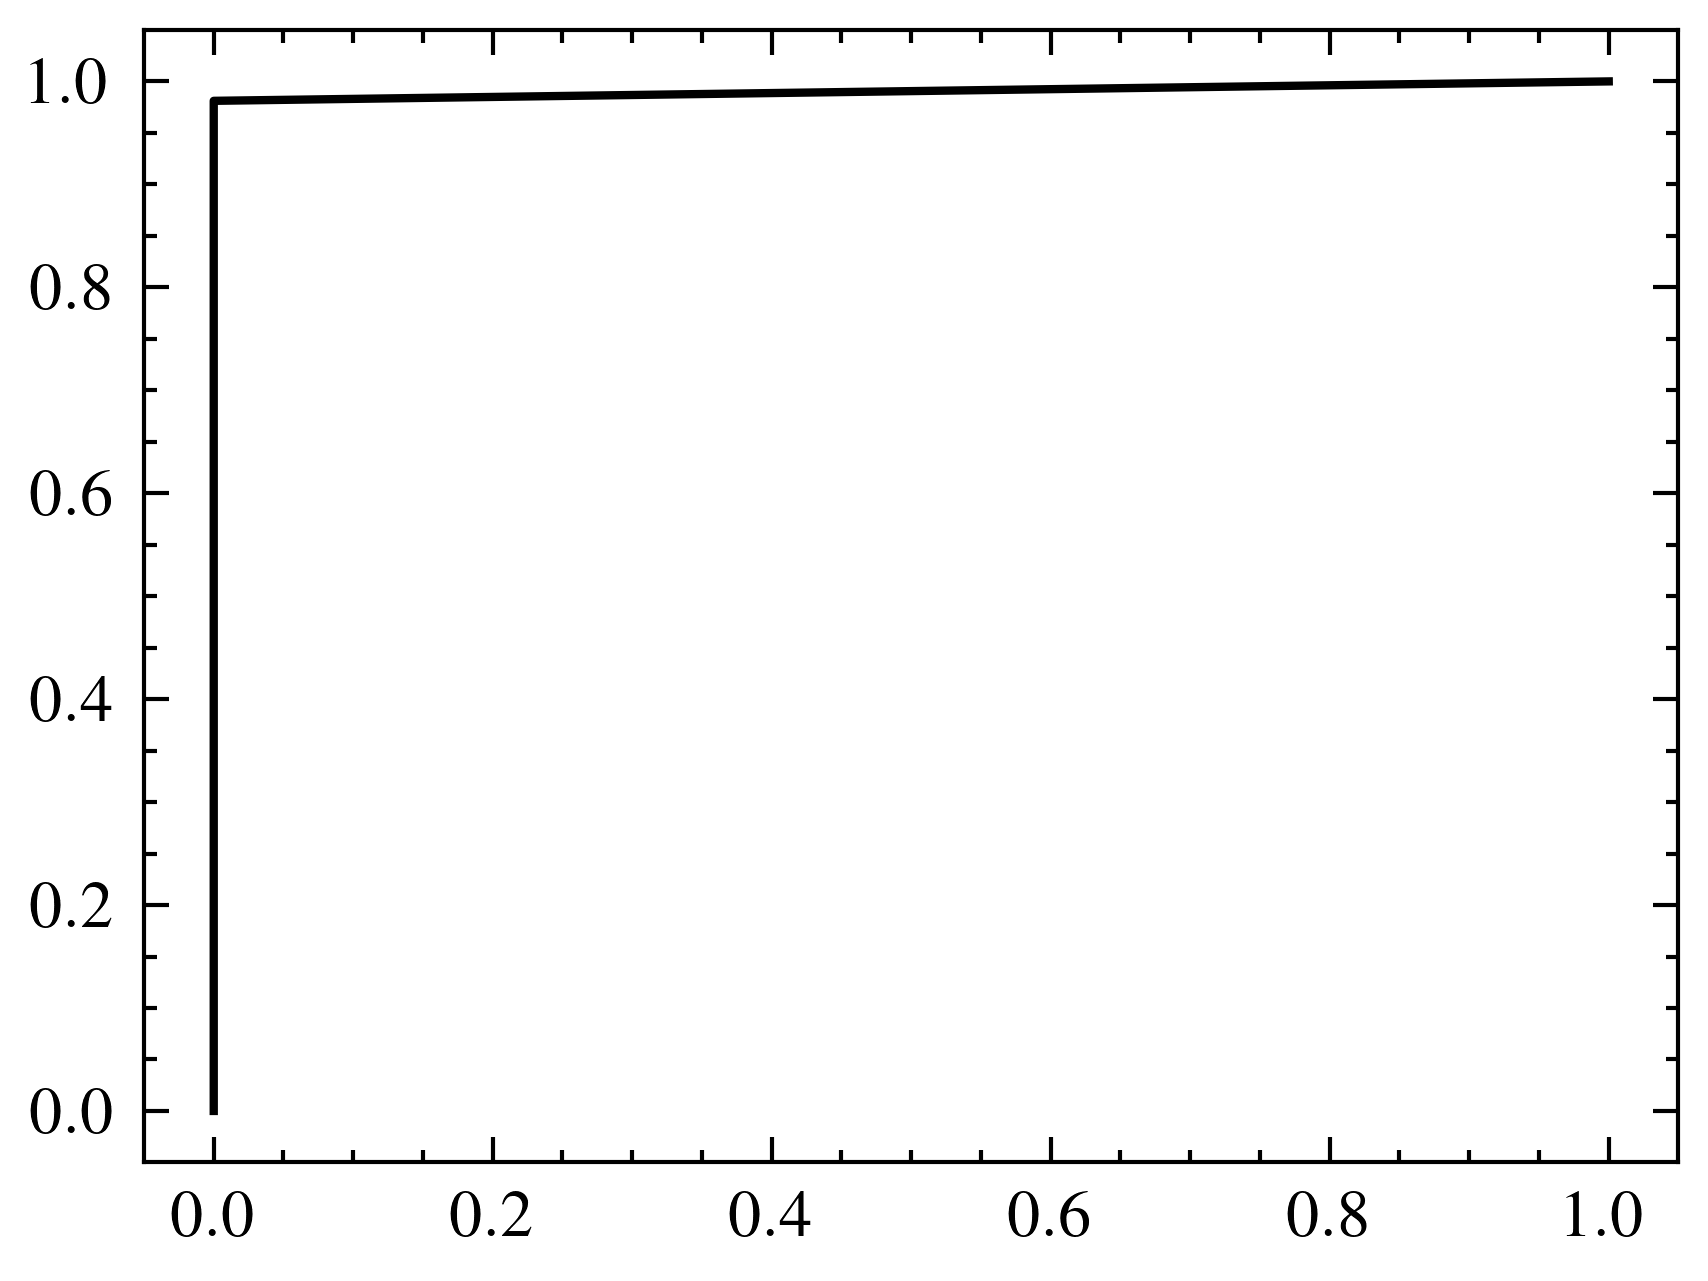

In [42]:
plt.plot(false_positive_rate, true_positive_rate)

In [44]:
test.to_csv('model_v3_test_df.csv')

In [35]:
svm_fpr,svm_tpr,thre = svm_train()

In [42]:
lr_fpr, lr_tpr, thre = lr_train()

In [28]:
knn_fpr, knn_tpr, thre = knn_train()

In [29]:
rf_fpr, rf_tpr, thre = rf_train()

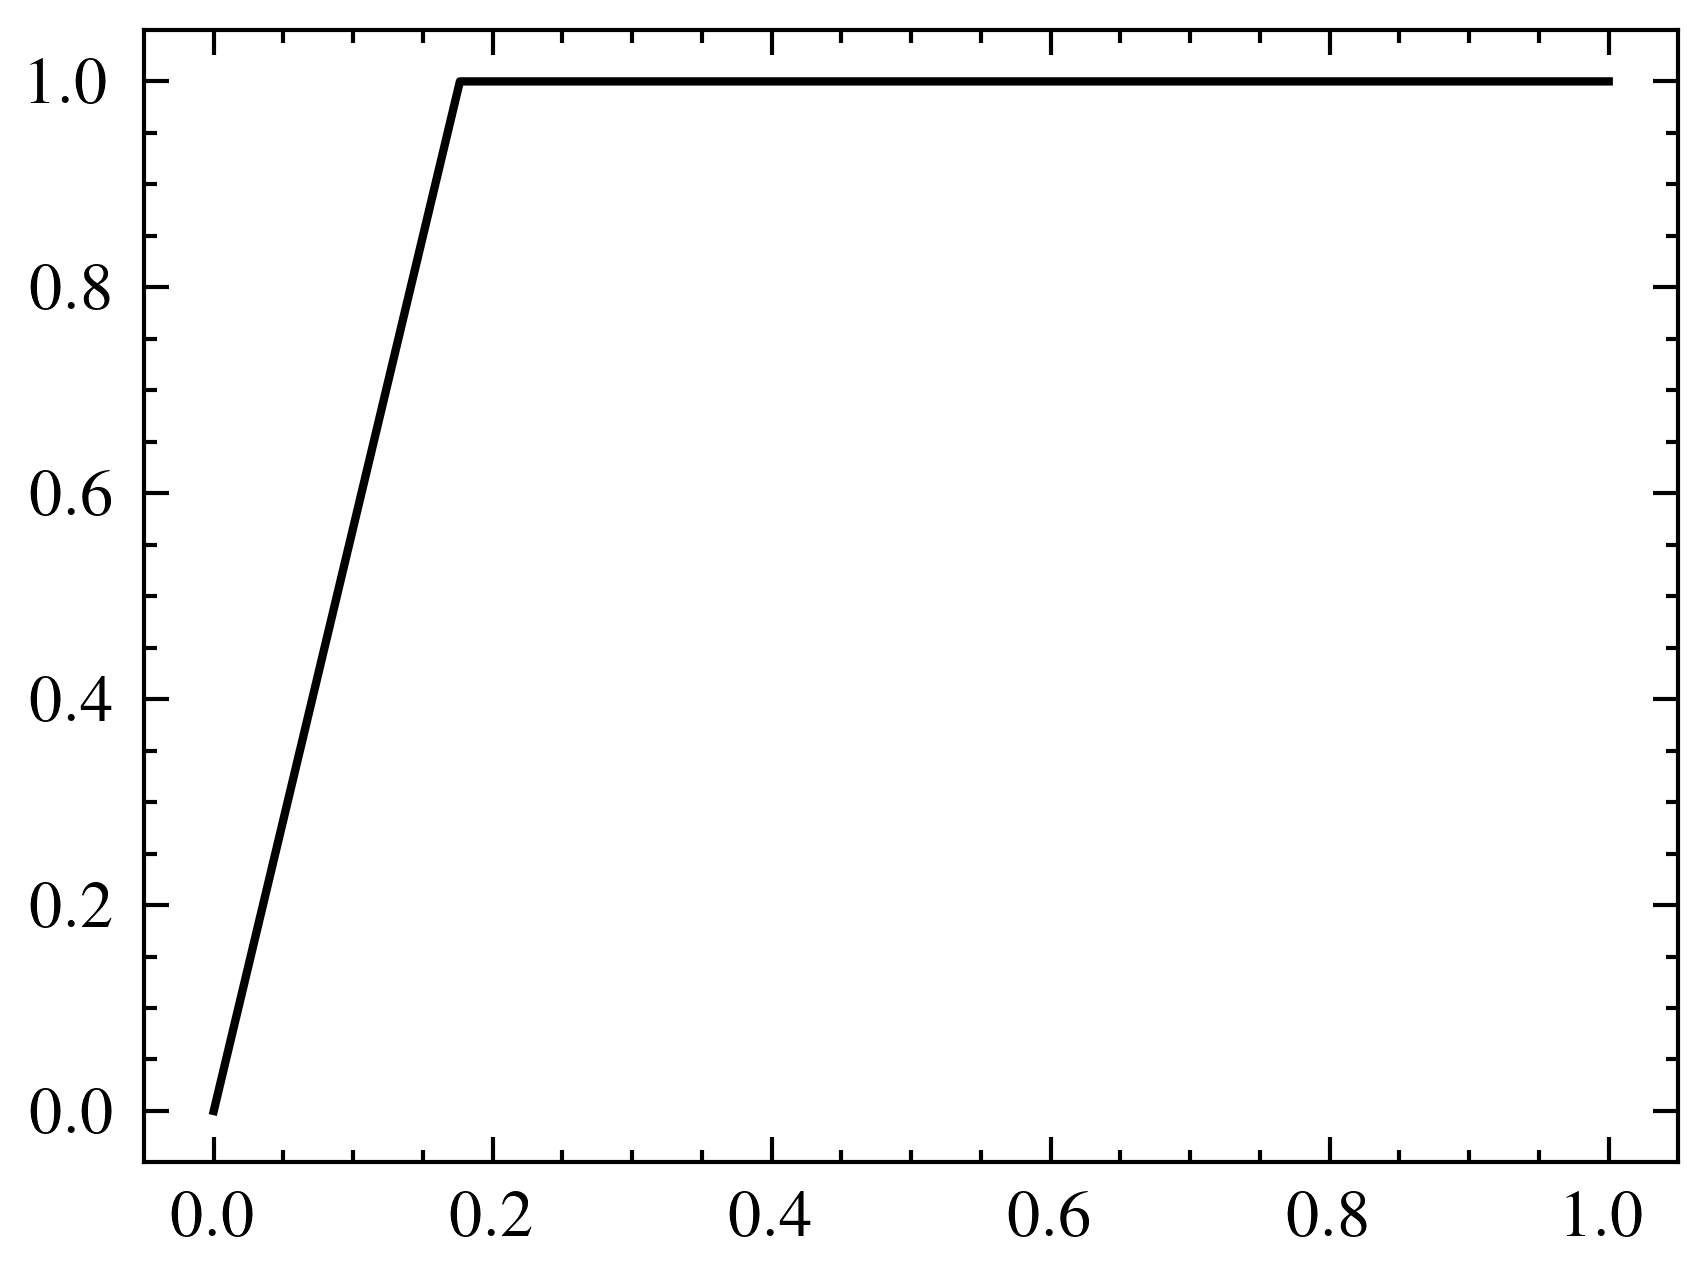

In [50]:
plt.plot(svm_fpr, svm_tpr)

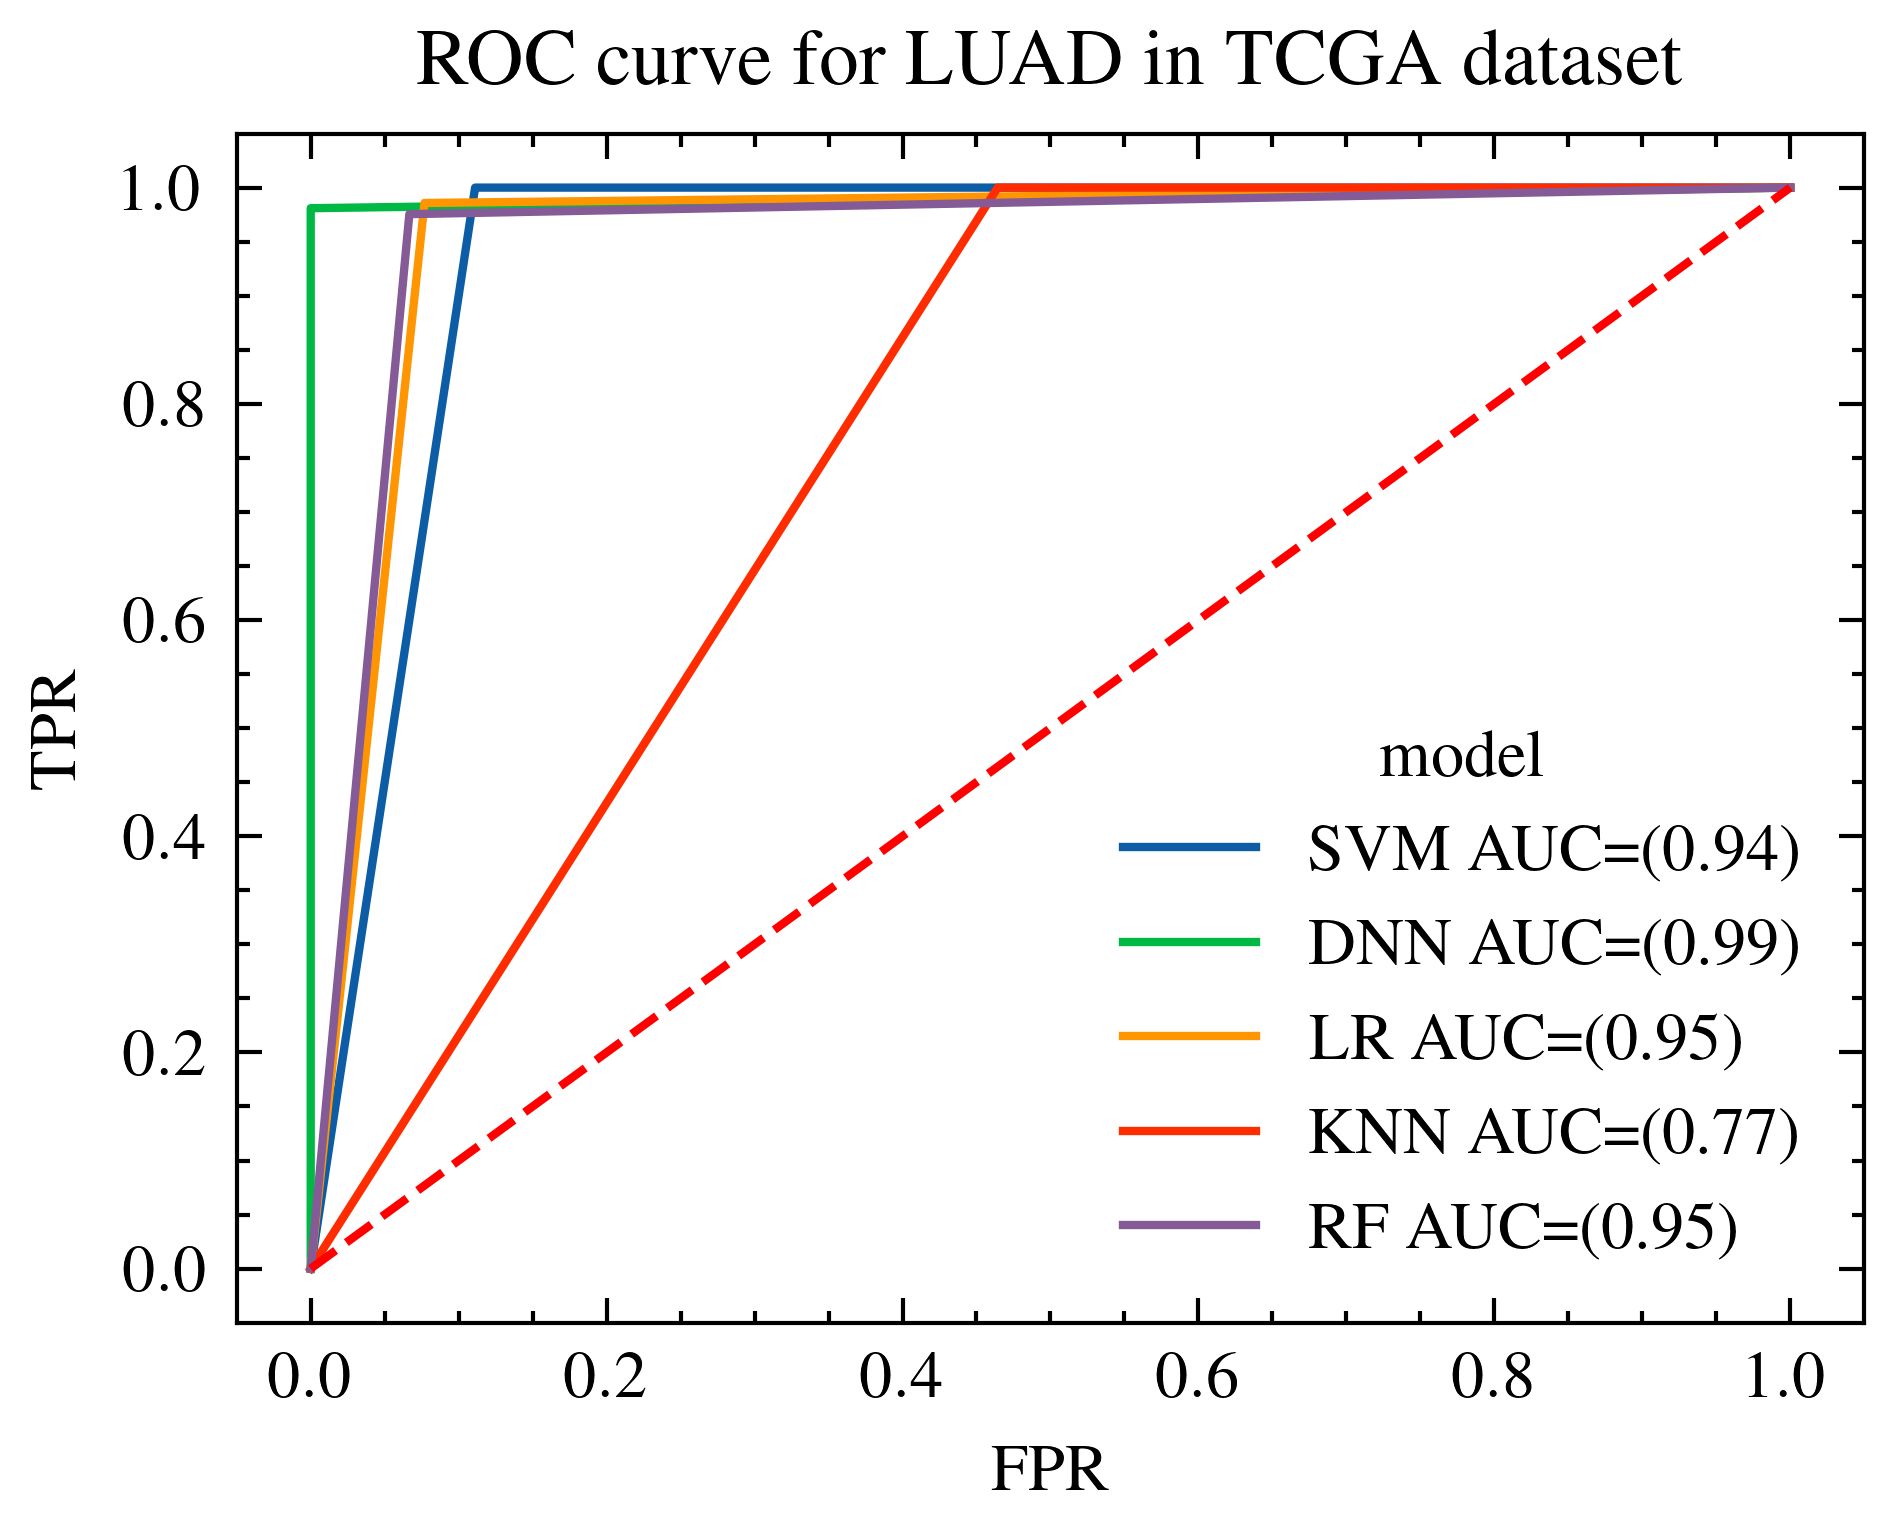

In [51]:

with plt.style.context(['science']):
    fig, ax = plt.subplots()        
    for p in ['SVM', 'DNN','LR','KNN','RF']: 
        fpr, tpr = get_ff(p)
        roc_auc=auc(fpr, tpr)
        ax.plot(fpr, tpr, label='%s AUC=(%.2f)' %(p, roc_auc)) 
    ax.plot([0,1],[0,1],'r--')
    ax.legend(loc='lower right') 
    ax.legend(title='model')       
    ax.set(xlabel='FPR')        
    ax.set(ylabel='TPR')
    plt.title('ROC curve for LUAD in TCGA dataset')
    #ax.autoscale(tight=True)        
    #fig.savefig('fig1.pdf')        
    fig.savefig('fig1.jpg', dpi=300)

In [15]:
def get_ff(model_name):
    if model_name == 'SVM':
        return svm_fpr, svm_tpr
    if model_name == 'DNN':
        return false_positive_rate, true_positive_rate
    if model_name == 'LR':
        return lr_fpr, lr_tpr
    if model_name == 'KNN':
        return knn_fpr, knn_tpr
    if model_name == 'RF':
        return rf_fpr, rf_tpr